In [54]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum

np.random.seed(0)

class Softmax():
    @staticmethod
    def compute(x):
        x = np.clip(x, 1e-15, 1 - 1e-15)
        e_x = np.exp(x - np.max(x, axis=0, keepdims=True))
        return e_x / np.sum(e_x, axis=0, keepdims=True)
    
    def compute_derivative(self, x):
        value = self.compute(x)
        return value * (1 - value)
    
class ReLU():
    @staticmethod
    def compute(x):
        return np.maximum(x, 0)
    
    @staticmethod
    def compute_derivative(x):
        return x > 0
    
class LeakyReLU:
    @staticmethod
    def compute(x, alpha=0.01):
        return np.where(x >= 0, x, alpha * x)

    @staticmethod
    def compute_derivative(x, alpha=0.01):
        return np.where(x >= 0, 1, alpha)
    
class Sigmoid():
    @staticmethod
    def compute(x):
        x = np.clip( x, -500, 500 )
        return 1 / (1 + np.exp(-x))

    def compute_derivative(self, x):
        return x * (1 - x)
    
class CrossEntropy():
    @staticmethod
    def compute(y, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return - (y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()

    @staticmethod
    def compute_derivative(y, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return - (y / y_pred) + (1 - y) / (1 - y_pred)
    
class MSE:
    @staticmethod
    def compute(y, y_pred):
        return ((y - y_pred) ** 2).mean()
    
    @staticmethod
    def compute_derivative(y, y_pred):
        return -2*(y - y_pred) / y.shape[0]
    
class RegressionError:
    @staticmethod
    def compute(y, y_pred):
        return (y - y_pred)
    
    @staticmethod
    def compute_derivative(y, y_pred):
        return (y - y_pred)
    

class Tanh:
    @staticmethod
    def compute(x):
        return np.tanh(x)

    @staticmethod
    def compute_derivative(x):
        return 1 - x ** 2
    
class Linear:
    @staticmethod
    def compute(x):
        return x

    @staticmethod
    def compute_derivative(x):
        return np.ones_like(x)

class NeuralNetworkStructure:
    def __init__(self, inputSize, outputSize, hiddenLayerSizes, hiddenLayerFunction, outputLayerFunction):
        self.inputSize = inputSize
        self.outputSize = outputSize
        self.hiddenLayerSizes = hiddenLayerSizes
        self.layersSizes = hiddenLayerSizes + [outputSize]
        self.activationFunction = [hiddenLayerFunction] * len(hiddenLayerSizes) + [outputLayerFunction]
        self.layerInput = [None] * len(self.layersSizes)
        self.layerOutput = [None] * len(self.layersSizes)

        self.initializeWeights()

    def initializeWeights(self):
        self.weights = []
        self.bias = []
        
        previousLayerSize = self.inputSize
        for layerSize in self.layersSizes:
            self.weights.append(np.random.rand(layerSize, previousLayerSize) - 0.5)
            self.bias.append(np.random.rand(layerSize, 1) - 0.5)
            previousLayerSize = layerSize
            

class NeuralNetwork:
    def __init__(self, neuralNetworkStructure, epochs, learningRate, lossFunction, partsCount = 1):
        self.structure = neuralNetworkStructure
        self.lossFunction = lossFunction
        self.learningRate = learningRate
        self.epochs = epochs
        self.partsCount = partsCount

    def Forward(self, X):
        previous_layer = X #np.reshape(X, (X.shape[0], 1))
        for id in range(len(self.structure.layersSizes)):
            self.structure.layerInput[id] = self.structure.weights[id].dot(previous_layer) + self.structure.bias[id]
            self.structure.layerOutput[id] = self.structure.activationFunction[id].compute(self.structure.layerInput[id])
            previous_layer = self.structure.layerOutput[id]
        return previous_layer
    
    
    def Backward(self, X, ExpectedY, PredictedY):
        previous_layer_error = self.lossFunction.compute_derivative(ExpectedY, PredictedY)
        
        for id in range(len(self.structure.layersSizes) -1, -1, -1):    
            previous_layer_output = self.structure.layerOutput[id - 1] if id != 0 else X
            
            delta = previous_layer_error * self.structure.activationFunction[id].compute_derivative(self.structure.layerOutput[id])
            deltaW = np.dot(delta, previous_layer_output.T) 
            deltaB = np.sum(delta, axis=1, keepdims=True)
            previous_layer_error = np.dot(self.structure.weights[id].T, delta)
                                        
            self.structure.weights[id] -= self.learningRate * deltaW / ExpectedY.shape[1]
            self.structure.bias[id] -= self.learningRate * deltaB / ExpectedY.shape[1]
    
    def one_hot(self, Y):
        one_hot_Y = np.zeros((Y.max() + 1, Y.size))
        one_hot_Y[Y, np.arange(Y.size)] = 1
        return one_hot_Y
    
    def Train(self, X, ExpectedY):
    
        #X = np.reshape(X, (-1, 1))
        #ExpectedY = np.reshape(ExpectedY, (-1, 1))
    
        predictedY = self.Forward(X)
        self.Backward(X, ExpectedY, predictedY)

    def Test(self, train_inputs, train_results, test_inputs, test_results, testAfterEpochs = 10, schuffleParts = True):
        one_hot_results = self.one_hot(train_results)

        for epoch in range(self.epochs):
            inputParts = np.array_split(train_inputs, self.partsCount, 1)
            resultsParts = np.array_split(one_hot_results, self.partsCount, 1)
            parts_range = list(range(len(inputParts)))
            
            if schuffleParts == True:
                np.random.shuffle(parts_range)
            
            for i in parts_range:
                self.Train(inputParts[i], resultsParts[i])
            
            if (epoch + 1) % testAfterEpochs == 0:        
                predictedY = self.Forward(test_inputs)
                correct = np.sum(np.argmax(predictedY, 0) == test_results)
                
                test_accuracy = correct / len(test_results)
                print(f"Epoch {epoch + 1}/{self.epochs}, Test Accuracy: {test_accuracy * 100:.2f}% Correct: {correct}, All: {len(test_results)} ")            
    
    
    
    def TestRegression(self, train_inputs, train_results, test_inputs, schuffleParts = True):
        prediction = []
        for epoch in range(self.epochs):
            
            inputParts = np.array_split(train_inputs, self.partsCount, 1)
            resultsParts = np.array_split(train_results, self.partsCount, 1)
            parts_range = list(range(len(inputParts)))
            
            if schuffleParts == True:
                np.random.shuffle(parts_range)
            
            for i in parts_range:
                self.Train(np.reshape(train_inputs, (-1, 1)).T, np.reshape(train_results, (-1, 1)).T)
            
            prediction = self.Forward(np.reshape(test_inputs, (-1, 1)).T)
            
            
        return prediction   


In [97]:
def GetClassificationData(name):
    file = pd.read_csv(name, sep=",")

    input = np.array(file[["x", "y"]])
    results = np.array(file["cls"] - 1)

    num_classes = results.max() + 1
    
    return input.T, results.T, num_classes

In [96]:
import numpy as np
import pandas as pd

train_vectors, train_results, num_classes = GetClassificationData("classification/data.simple.train.100.csv")
test_vectors, test_results, _ = GetClassificationData("classification/data.simple.test.100.csv")

nnS = NeuralNetworkStructure(
    inputSize = 2, 
    outputSize = 2, 
    hiddenLayerSizes = [8], 
    hiddenLayerFunction = Sigmoid(), 
    outputLayerFunction = Softmax())

nn = NeuralNetwork(  
    epochs = 1000, 
    learningRate = 0.1,
    neuralNetworkStructure = nnS,
    lossFunction = CrossEntropy())

nn.Test(train_vectors, train_results, test_vectors, test_results)

Epoch 1/1000, Test Accuracy: 53.00% Correct: 53, All: 100 
Epoch 2/1000, Test Accuracy: 53.00% Correct: 53, All: 100 
Epoch 3/1000, Test Accuracy: 53.00% Correct: 53, All: 100 
Epoch 4/1000, Test Accuracy: 53.00% Correct: 53, All: 100 
Epoch 5/1000, Test Accuracy: 53.00% Correct: 53, All: 100 
Epoch 6/1000, Test Accuracy: 53.00% Correct: 53, All: 100 
Epoch 7/1000, Test Accuracy: 53.00% Correct: 53, All: 100 
Epoch 8/1000, Test Accuracy: 53.00% Correct: 53, All: 100 
Epoch 9/1000, Test Accuracy: 53.00% Correct: 53, All: 100 
Epoch 10/1000, Test Accuracy: 53.00% Correct: 53, All: 100 
Epoch 11/1000, Test Accuracy: 53.00% Correct: 53, All: 100 
Epoch 12/1000, Test Accuracy: 53.00% Correct: 53, All: 100 
Epoch 13/1000, Test Accuracy: 53.00% Correct: 53, All: 100 
Epoch 14/1000, Test Accuracy: 53.00% Correct: 53, All: 100 
Epoch 15/1000, Test Accuracy: 53.00% Correct: 53, All: 100 
Epoch 16/1000, Test Accuracy: 53.00% Correct: 53, All: 100 
Epoch 17/1000, Test Accuracy: 53.00% Correct: 53,

In [69]:
import numpy as np
import pandas as pd

train_vectors, train_results, num_classes = GetClassificationData("classification/data.simple.train.10000.csv")
test_vectors, test_results, _ = GetClassificationData("classification/data.simple.test.10000.csv")

nnS = NeuralNetworkStructure(
    inputSize = 2, 
    outputSize = 2, 
    hiddenLayerSizes = [8], 
    hiddenLayerFunction = Sigmoid(), 
    outputLayerFunction = Softmax())

nn = NeuralNetwork(  
    epochs = 1000, 
    learningRate = 0.1,
    neuralNetworkStructure = nnS,
    lossFunction = CrossEntropy())

nn.Test(train_vectors, train_results, test_vectors, test_results)

Epoch 100/1000, Test Accuracy: 50.42% Correct: 5042, All: 10000 
Epoch 200/1000, Test Accuracy: 55.48% Correct: 5548, All: 10000 
Epoch 300/1000, Test Accuracy: 83.84% Correct: 8384, All: 10000 
Epoch 400/1000, Test Accuracy: 91.82% Correct: 9182, All: 10000 
Epoch 500/1000, Test Accuracy: 94.79% Correct: 9479, All: 10000 
Epoch 600/1000, Test Accuracy: 96.53% Correct: 9653, All: 10000 
Epoch 700/1000, Test Accuracy: 97.40% Correct: 9740, All: 10000 
Epoch 800/1000, Test Accuracy: 97.77% Correct: 9777, All: 10000 
Epoch 900/1000, Test Accuracy: 98.16% Correct: 9816, All: 10000 
Epoch 1000/1000, Test Accuracy: 98.46% Correct: 9846, All: 10000 


In [88]:
import numpy as np
import pandas as pd

train_vectors, train_results, num_classes = GetClassificationData("classification/data.three_gauss.train.10000.csv")
test_vectors, test_results, _ = GetClassificationData("classification/data.three_gauss.test.10000.csv")

nnS = NeuralNetworkStructure(
    inputSize = 2, 
    outputSize = num_classes, 
    hiddenLayerSizes = [12], 
    hiddenLayerFunction = Sigmoid(), 
    outputLayerFunction = Softmax())

nn = NeuralNetwork(  
    epochs = 1000, 
    learningRate = 0.05,
    neuralNetworkStructure = nnS,
    lossFunction = CrossEntropy())

nn.Test(train_vectors, train_results, test_vectors, test_results)

Epoch 100/1000, Test Accuracy: 30.56% Correct: 9167, All: 30000 
Epoch 200/1000, Test Accuracy: 90.12% Correct: 27035, All: 30000 


KeyboardInterrupt: 

In [78]:
def convert_range(data, range_min, range_max):
    old_min = data.min()
    old_max = data.max()
    return (((data - old_min) * (range_max - range_min)) / (old_max - old_min)) + range_min

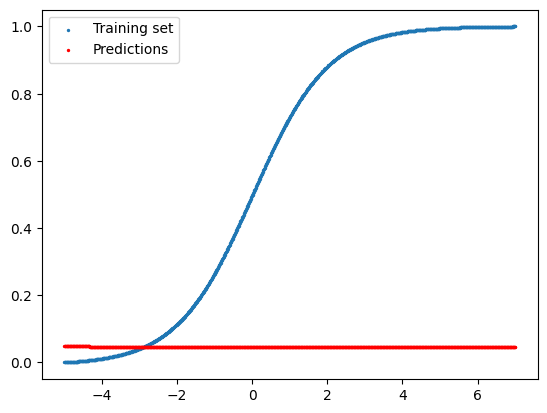

In [89]:
import numpy as np
import pandas as pd

test = pd.read_csv("regression/data.activation.test.500.csv", sep=",")
train = pd.read_csv("regression/data.activation.train.500.csv", sep=",")

train_vectors = np.array(train["x"]).T
train_results = convert_range(np.array(train["y"]), 0, 1).T
test_vectors = np.array(test["x"]).T
test_results = convert_range(np.array(test["y"]), 0, 1).T

nnS = NeuralNetworkStructure(
    inputSize = 1, 
    outputSize = 1, 
    hiddenLayerSizes = [3, 2, 2], 
    hiddenLayerFunction = Sigmoid(), 
    outputLayerFunction = Linear())

nn = NeuralNetwork(  
    epochs = 3, 
    learningRate = 0.01,
    neuralNetworkStructure = nnS,
    lossFunction = MSE())

predictedPoints = nn.TestRegression(train_vectors, train_results, test_vectors)

import matplotlib.pyplot as plt

plt.scatter(test_vectors, test_results, label='Training set', s=2)
plt.scatter(test_vectors, predictedPoints, color='r', label='Predictions', s=2)
plt.legend()
plt.show()


In [81]:
import numpy as np
from mnist.loader import MNIST

mndata = MNIST("mnist")
mndata.gz = True

train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

train_images = np.array(train_images).T
train_labels = np.array(train_labels).T
test_images = np.array(test_images).T
test_labels = np.array(test_labels).T

train_images = train_images / 255.0
test_images = test_images / 255.0

num_classes = 10

np.random.seed(0)

nnS = NeuralNetworkStructure(
    inputSize = 784, 
    outputSize = 10, 
    hiddenLayerSizes = [392], 
    hiddenLayerFunction = Sigmoid(), 
    outputLayerFunction = Softmax())

nn = NeuralNetwork(  
    epochs = 1200, 
    learningRate = 0.01,
    neuralNetworkStructure = nnS,
    lossFunction = CrossEntropy(),
    partsCount = 5000
)

nn.Test(train_images, train_labels, test_images, test_labels, testAfterEpochs=1)

Epoch 1/1200, Test Accuracy: 54.21% Correct: 5421, All: 10000 
Epoch 2/1200, Test Accuracy: 60.94% Correct: 6094, All: 10000 
Epoch 3/1200, Test Accuracy: 62.95% Correct: 6295, All: 10000 
Epoch 4/1200, Test Accuracy: 64.31% Correct: 6431, All: 10000 
Epoch 5/1200, Test Accuracy: 65.19% Correct: 6519, All: 10000 
Epoch 6/1200, Test Accuracy: 66.40% Correct: 6640, All: 10000 
Epoch 7/1200, Test Accuracy: 65.97% Correct: 6597, All: 10000 
Epoch 8/1200, Test Accuracy: 66.93% Correct: 6693, All: 10000 
Epoch 9/1200, Test Accuracy: 66.57% Correct: 6657, All: 10000 
